# Creating Donut Charts from Survey Responses

Recently I helped conduct a survey about student engagement at our school and I needed to create a way to clearly present the results to the entire faculty and staff. I decided that since most people enjoy pie charts, that might be a good format for the data. However, knowing that they aren't the best representation, I decided to use their more intuitive cousin: **Donut Charts** [[1](http://www.businessinsider.com/pie-charts-are-the-worst-2013-6), [2](https://www.quora.com/How-and-why-are-pie-charts-considered-evil-by-data-visualization-experts), [3](https://blog.funnel.io/why-we-dont-use-pie-charts-and-some-tips-on-better-data-visualizations)]. Donut charts also have their drawbacks, but I felt that for the comparisions that I wanted to do a bar chart would have been very tough to read for a general audience [[4](http://www.datarevelations.com/with-great-power-comes-great-responsibility-or-think-before-you-use-a-donut-chart.html), [5](https://www.evolytics.com/blog/tableau-201-how-to-make-donut-charts/), [6](http://www.vizwiz.com/2012/06/donut-charts-are-worse-than-pie-charts.html), [7](https://ux.stackexchange.com/questions/105837/pie-chart-vs-doughnut-chart-when-to-use-each)].  

In [15]:
import pandas as pd
import numpy as np
import scipy

from datetime import datetime
import re

import glob
import os

import matplotlib.pyplot as plt

%matplotlib inline

Setting the default font sizes for `matplotlib`

In [230]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Create color lists that mimic Tableau. Tableau 20 is the standard color scheme but the `tableau5` is the set of colors I used for the Faculty survey earlier in the year and visualized with Tableau. That survey had 5 responses (strongly disagree to strongly agree). The student on did not include a neutral response and so I removed the neutral response to come up with 'tableau4'. This scheme was applied to all of the answer choices even though they varied. This made the visual assignment of positive/negative consistent throughout. After we define the colors we can create a dictionary that will hold our label:value map. (We actually need to create two dictionaries because the response 'some' is used in two different contexts.)

In [3]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

tableau5 = [(200,82,0),(255,188,121),(200,208,217),(163,204,233),(17,122,170)]
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

for i in range(len(tableau5)):    
    r, g, b = tableau5[i]    
    tableau5[i] = (r / 255., g / 255., b / 255.)
    
tableau4 = tableau5[:2] + tableau5[-2:]

response_order = ['Strongly Disagree', 'Disagree', 'Agree', 'Strongly Agree']
response_order_2 = ['Never', 'Rarely', 'Sometimes', 'Often']
response_order_3 = ['None', 'Some', 'Most', 'All']
response_order_4 = ['Not at all', 'Very little', 'Sometimes', 'Very much']

color_dict = {x:y for x,y in zip(response_order, tableau4)}
for x,y in zip(response_order_2, tableau4):
    color_dict[x] = y
for x,y in zip(response_order_3, tableau4):
    color_dict[x] = y

color_dict_2 = {x:y for x,y in zip(response_order_4, tableau4)}

Import the most recent excel file in the directory

In [4]:
latest_survey_file = max(glob.iglob('*.xlsx'), key=os.path.getctime)

### Fixing the Timestamps

When I copied the timestamps from one sheet to another, they differed on the order of milliseconds for some reason. In 
order to properly `join()` the data later (since that was my primary key) I needed to ensure that the records were consistent across the dataset. The timestamp showed the second the survey was completed, so it should have been the same across the set. Luckily I was dealing with a small number of records and was able to visually inspect the dataset. I noticed that the keys were mismatched in the millisecond range but that they were the same when rounded to the nearest second. The function `date_fix()` uses the millisecond portion to determine if the seconds should be rounded or not. There were two values that occurred within that 0.5 second window, so I end up losing one response.

In [72]:
dummy_day = '2099-04-11 13:24:15'

def date_fix(date):
    try:
        stem, final, rounding = re.search(r'(.*)(\d{2})\.(\d{4,6})$', str(date)).groups()
        if int(rounding[0]) >4:
            return datetime.strptime('{}{}'.format(stem,int(final)+1), '%Y-%m-%d %H:%M:%S')
        return datetime.strptime('{}{}'.format(stem,final), '%Y-%m-%d %H:%M:%S')
    except ValueError: 
        return datetime.strptime(dummy_day, '%Y-%m-%d %H:%M:%S')
    except AttributeError:
        return datetime.strptime(dummy_day, '%Y-%m-%d %H:%M:%S')
    
raw_responses = pd.read_excel(
    latest_survey_file,
    sheetname='Raw Responses',
    parse_dates = True,
    date_parser = date_fix,
    index_col='Timestamp'
)
assert raw_responses[raw_responses.index == dummy_day].shape[0] == 0
print('raw_responses: ',raw_responses.shape[0],raw_responses.index.nunique())

resp_w_alt_quest = pd.read_excel(
    latest_survey_file,
    sheetname='Responses with Altered Question',
    parse_dates = True,
    date_parser = date_fix,
    index_col='Timestamp'
)
assert resp_w_alt_quest[resp_w_alt_quest.index == dummy_day].shape[0] == 0
print('resp_w_alt_quest: ',resp_w_alt_quest.shape[0],resp_w_alt_quest.index.nunique())

quest_meta = pd.read_excel(
    latest_survey_file,
    sheetname='Question Metadata',
    index_col='Survey Question'
)
      
demos = pd.read_excel(
    latest_survey_file,
    sheetname='Demographics',
    parse_dates = True,
    date_parser = date_fix,
    index_col='Timestamp'
)
assert demos[demos.index == dummy_day].shape[0] == 0
print('demos: ',demos.shape[0],demos.index.nunique())

raw_responses:  260 259
resp_w_alt_quest:  260 259
demos:  260 259


After importing each sheet as a dataframe, I want to extract the categories of interest and the grade levels. This will allow me to search through the data for specific categories and grade levels.

In [6]:
faculty_group_disc = quest_meta[quest_meta['Faculty Group Discussion'] == 'Y']
categories = faculty_group_disc.Category.unique().tolist()

grade_levels = sorted(resp_w_alt_quest['What is your current grade?'].unique().tolist())

We create a new dataframe that contains only the relevant questions called `survey_results`. This is joined with the demographic information to produce a new table. We can prevent losing the 'overlapping' data point by finding the set of duplicate indicies and concatenating a top slice which contains the first duplicate and a bottom slice which containes the last duplicate. This preserves the information in the new dataframe.

In [188]:
survey_results = resp_w_alt_quest[faculty_group_disc.Question.tolist()]
print('\t\t\t\tRows Unique')
print('After selecting questions:\t',survey_results.shape[0],survey_results.index.nunique())

survey_results = survey_results.join(
                    demos,
                    how = 'inner'
                ).dropna()

print('After join:\t\t\t',survey_results.shape[0], survey_results.index.nunique())

dup = survey_results.index.get_loc(survey_results.index.get_duplicates()[0])
start = dup.start
end = dup.stop
survey_results = pd.concat([survey_results.iloc[:start+1], survey_results.iloc[end-1:]])
print('After slicing:\t\t\t',survey_results.shape[0], survey_results.index.nunique())

				Rows Unique
After selecting questions:	 260 259
After join:			 261 258
After slicing:			 259 258


In [191]:
questions_of_interest = survey_results.columns.tolist()[:-9]
skip = ['If you have ever been bored in class, why? ', 'Timestamp']
questions_of_interest = [q for q in questions_of_interest if q not in skip] 
print('- ', end="", flush=True)
print('\n- '.join(questions_of_interest))

- I am an important part of my high school community
- I am comfortable being myself at this school
- I can be creative in classroom assignments and projects
- Skipped school, faked an illness to stay home, or deliberately come to school late because of disinterest in school
- Teachers engage me in classroom discussions
- About how many of your classes challenge you to your full academic potential?
- I am motivated by my desire to get good grades
- I am motivated by my desire to learn
- I am motivated by teachers who encourage me
- I enjoy working on tasks that require a lot of thinking and mental effort
- I like discussions in which there are no clear answers
- I put forth a great deal of effort when doing my school work
- I see how the work I am doing now will help me after high school
- In about how many classes do you give your maximum effort?
- In about how many classes do you put forth very little effort?
- In general, I am excited about my classes
- My school work makes me curio

### Demonstrating Grouping

For each question, I need aggregate data. That is acheived by using the following two variations of the pandas `groupby()` function: one to group on a total population level and the other to group by class year / grade level.

In [132]:
community_whole = survey_results.\
            groupby(['I am an important part of my high school community']).\
            size().\
            reset_index(name = 'Counts').set_index(
                'I am an important part of my high school community')
community_whole

,Counts
I am an important part of my high school community,
Agree,126
Disagree,77
Strongly Agree,36
Strongly Disagree,22


In [192]:
community = survey_results.\
            groupby(['Grade Level', 'I am an important part of my high school community']).\
            size().\
            reset_index(name = 'Counts').set_index(
                'I am an important part of my high school community')
community

,Grade Level,Counts
I am an important part of my high school community,,
Agree,10th (Sophomore),36
Disagree,10th (Sophomore),27
Strongly Agree,10th (Sophomore),7
Strongly Disagree,10th (Sophomore),4
Agree,11th (Junior),24
Disagree,11th (Junior),24
Strongly Agree,11th (Junior),14
Strongly Disagree,11th (Junior),7
Agree,12th (Senior),38


### Generalizing the Aggregator

To make it easier to iterate through all of the questions and grade levels, I want to make a function that does both aggregates and stores them during the loops. `aggregator` returns two dataframes: one aggregated by response and the other by response and grade level.

In [193]:
def aggregator(question):
    return survey_results.\
            groupby(['Grade Level', question]).\
            size().\
            reset_index(name = 'Counts').set_index(question), survey_results.\
            groupby([question]).\
            size().\
            reset_index(name = 'Counts').set_index(question)

In order to make sure the responses are sorted in a logical order, I wrote the `reorder` function which takes the dataframe and returns the counts, labels and colors in the correct order. I needed to add the `_responses` and `_colors` objects so that I could generalize to each of the question response types. Since the response "some" shows up in two different contexts, I needed to utilize two different color dictionaries. `response_map()` chooses which set of responses will be passed into `reorder`.

In [196]:
def reorder(df, responses, special = False):
    _counts = []
    _responses = []
    _colors = []
    for x in responses:
        try:
            _counts.append(df.loc[x,'Counts'])
            _responses.append(x)
            if special:
                _colors.append(color_dict_2[x])
            else:
                _colors.append(color_dict[x])
        except:
            pass
    return _counts, _responses, _colors

def response_map(df):
    special = False
    if df.index.unique()[0] in response_order:
        responses = response_order
    elif df.index.unique()[0] in response_order_2:
        responses = response_order_2
    elif df.index.unique()[0] in response_order_3:
        responses = response_order_3
    elif df.index.unique()[0] in response_order_4:
        responses = response_order_4
        special = True
    else:
        raise ValueError('A very specific bad thing happened: Wrong responses!')
    return responses, special

## The Coup de Grâce: The Donut Plot

Here I set up my donut plot function `donut()`. The data, label and title arguments are required, so it knows what to plot and how to label it, and so that I know what it's a plot of. I've added kwargs to make it easier to use differing color schemes, turn saving on/off, indicate the save method, turn viewing the plot on/off and altering the figure sizes.

The function is generalized for both the grade level and overall level plots.

In [232]:
def donut(data, label, title, y = 0.45, colors = tableau4,
          save = True, show = False, grade_level = False,
          figsize=(6,3), figsize_w=(6,3)):
    plt.figure(figsize=figsize, dpi=300, facecolor='w')
    plt.pie(data,
            labels=label,
            autopct='%d%%',
            pctdistance = 0.65,
            wedgeprops = { 'linewidth' : 7, 'edgecolor' : None },
            colors = colors
           )
    plt.axis('equal')
    p = plt.gcf()
    p.gca().add_artist(plt.Circle( (0,0), 0.8, color='white'))
    plt.title(title, y = y, fontweight='bold', fontsize = BIGGER_SIZE)
    plt.subplots_adjust(right=0.9)
    plt.tight_layout()
    if save:
        if grade_level:
            plt.savefig('Sample_Figures/' + re.sub(r'/','-', question) +\
                        ' - ' + grade + '.png', 
                        dpi=600, 
                        orientation = 'landscape',
                        transparent=True,
                        )
        else:
            plt.savefig('Sample_Figures/' + re.sub(r'/','-', question)  + '.png', 
                        dpi=600, 
                        figsize=figsize_w,
                        orientation = 'landscape',
                        transparent=True,
                        )
    if show:
        plt.show()
    plt.close()

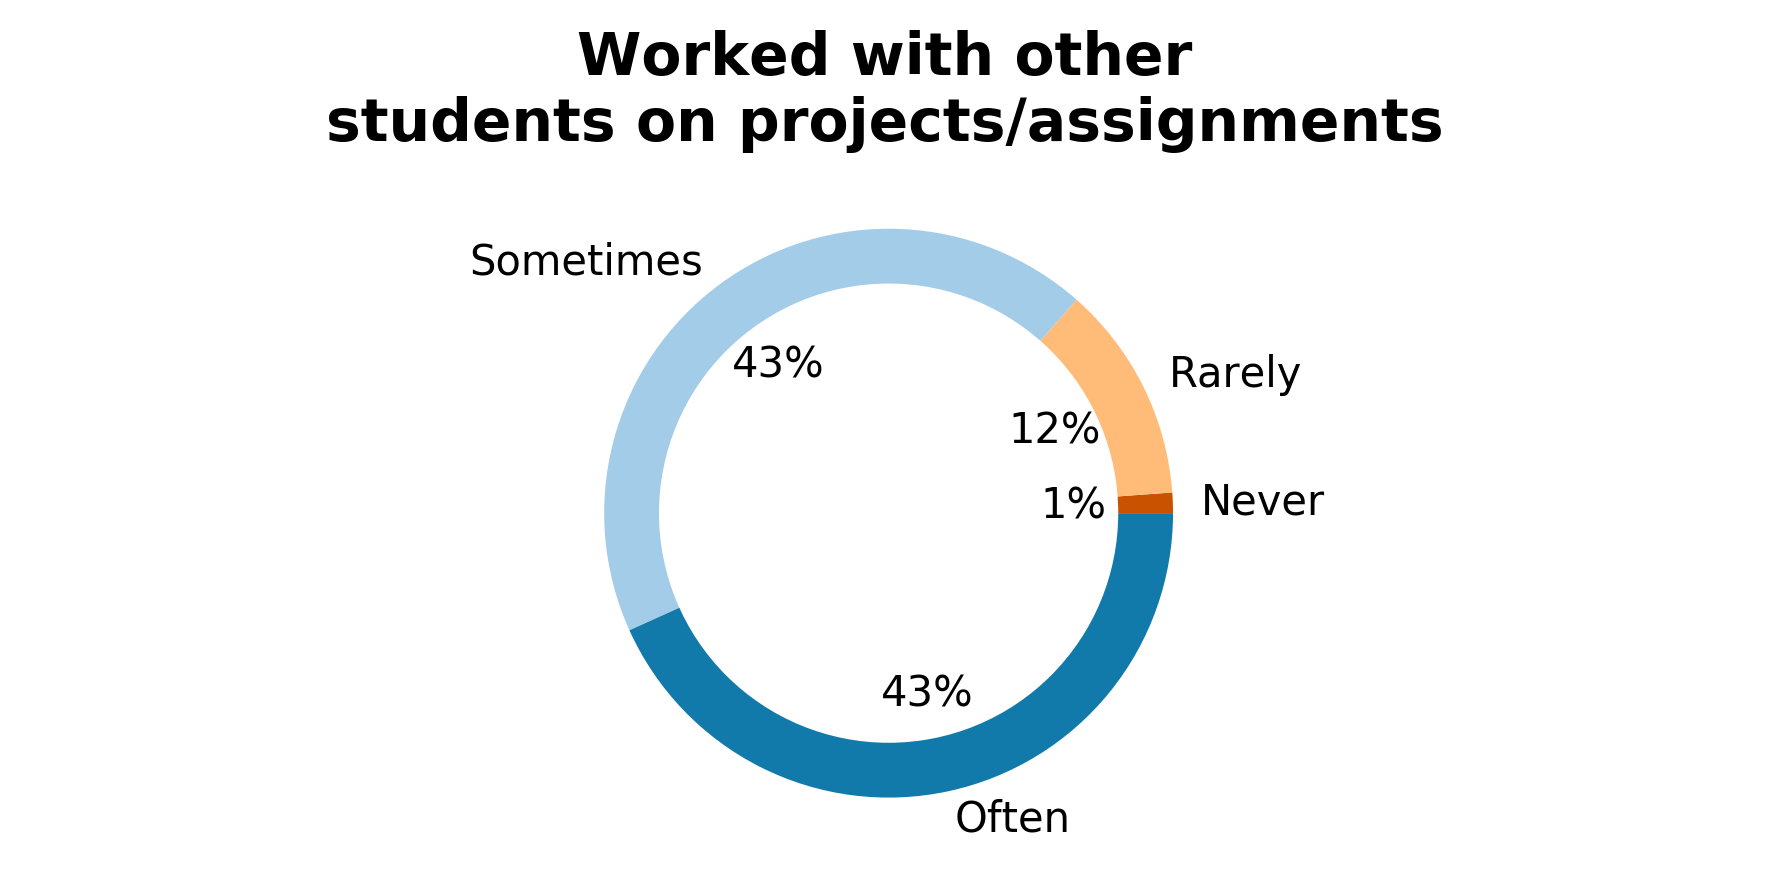

In [234]:
# Initialize question and grade
# They are otherwise handled by the loop
question = questions_of_interest[-1]
grade = None

df, df_w = aggregator(question)
responses, special = response_map(df)
    
_counts, _responses, _colors = reorder(df_w, 
                                        responses, 
                                        special)
donut(
    _counts,
    _responses,
    ' '.join(question.split()[:len(question.split()) // 2]) + '\n' + \
                ' '.join(question.split()[len(question.split()) // 2:]),
    y = 1.05,
    colors = _colors,
    show = True
)

In [235]:
for question in questions_of_interest:
    grade = None
    df, df_w = aggregator(question)
    responses, special = response_map(df)
    
    _counts, _responses, _colors = reorder(df_w, 
                                           responses, 
                                           special)
    
    
    donut(
        _counts,
        _responses,
        ' '.join(question.split()[:len(question.split()) // 2]) + '\n' + \
                 ' '.join(question.split()[len(question.split()) // 2:]),
        y = 1.05,
        colors = _colors,
        show = False,
         )
    
    for grade in grade_levels:
        _counts, _responses, _colors = reorder(df[df['Grade Level'] == grade],
                                               responses,
                                               special)
        donut(
            _counts,
            _responses,
            re.search(r'\((.*)\)',grade).group(1),
            colors = _colors,
            show = False,
            grade_level = True
             )